In [1]:
import os
import pytesseract
import math
from typing import Tuple, Union
import cv2
import imutils
import numpy as np
from deskew import determine_skew
from matplotlib import pyplot as plt
from PIL import Image
import easyocr
from skimage.filters import threshold_otsu, threshold_local
import doxapy
from scipy.ndimage import rotate
import pandas as pd
import re
from cv2 import dnn_superres
from keras.models import load_model

In [2]:
# Function for thresholding
def otsuThres(image):
    _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binarized

def adaptThres(image):
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

def binarizeModule(image):
    binary_image = np.empty(image.shape, dtype=np.uint8)

    wan = doxapy.Binarization(doxapy.Binarization.Algorithms.WAN)
    wan.initialize(image)
    wan.to_binary(binary_image, {"window": int(image.shape[1] * 0.2), "k": 0.2})

    return binary_image

def binarize0(image):
    # Apply Gaussian blur to the image
    estimated_kernel_size = int(max(image.shape) / 100) * 2 + 1
    blurred = cv2.GaussianBlur(image, (estimated_kernel_size, estimated_kernel_size), 0)
    
    # Calculate a local threshold value
    gaussian_thresh = threshold_local(blurred, block_size=101, method='gaussian', mode='reflect')
    
    # Convert the image to binary using the threshold value
    bw_image = blurred > gaussian_thresh
    
    # Convert the binary image to a uint8 NumPy array and return it
    return (bw_image * 255).astype(np.uint8)

In [3]:
# Simple function for pre-processing
def readImage(image):
        return cv2.imread(image)

def grayscale(image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def denoise(image):
        return cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

def dilate(image):
        kernel = np.ones((5,5),np.uint8)
        return cv2.dilate(image, kernel, iterations = 1)
    
def erode(image):
        kernel = np.ones((5,5),np.uint8)
        return cv2.erode(image, kernel, iterations = 1)

def opening(image):
        kernel = np.ones((5,5),np.uint8)
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def canny(image):
        return cv2.Canny(image, 100, 200)

In [ ]:
# Complicated function for pre-processing
# Temporarily unused
'''def enhance(image):
    # Initialize super resolution object
    sr = dnn_superres.DnnSuperResImpl_create()

    # Read the model
    sr.readModel(r"LapSRN_x8.pb")

    # Set the model and scale
    sr.setModel('lapsrn', 4)

    # If you have CUDA support
    sr.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    sr.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    # Upsample the image
    upscaled = sr.upsample(image)

    # Traditional method - bicubic
    bicubic = cv2.resize(image, (upscaled.shape[1], upscaled.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Return the upscaled and bicubic images
    return bicubic'''

def markContour3(image):
    # Find contours. RETR_EXTERNAL means that we ignore nested contours (contours within contours).
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the image to draw contours on
    image_with_contours = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

    # Iterate over the contours, filter out small ones and those that are wider than they are tall
    # Then sort them by bounding box area
    valid_contours = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) > 0.009 * image.size and cv2.contourArea(cnt) < 0.2 * image.size and cv2.boundingRect(cnt)[2] < cv2.boundingRect(cnt)[3]]
    valid_contours.sort(key=lambda x: x[0])  # Sort by x coordinate

    # Check if valid_contours is empty
    if not valid_contours:
        print('No valid contours found.')
        return image_with_contours, []

    # Find the maximum height among the contours
    max_height = max([h for _, _, _, h in valid_contours])

    # Draw contours on the image copy and print their areas
    char_images = []
    for contour in valid_contours:
        x, y, w, h = contour
        cv2.rectangle(image_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        cropped = image[y:y+h, x:x+w]
        # Pad the bottom of the cropped image with zeros if necessary
        if h < max_height:
            cropped = np.pad(cropped, ((0, max_height - h), (0, 0)), 'constant', constant_values=0)
        # Resize the cropped image to the input size expected by your model
        resized = cv2.resize(cropped, (40, 60))
        char_images.append(resized)

    return image_with_contours, char_images



def markContour(image):
    # Find contours. RETR_EXTERNAL means that we ignore nested contours (contours within contours).
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the image to draw contours on
    image_with_contours = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

    # Iterate over the contours, calculate bounding box for each contour and store in a list
    bounding_boxes = [cv2.boundingRect(cnt) for cnt in contours]

    # Calculate areas of the bounding boxes
    areas = [w*h for _, _, w, h in bounding_boxes]

    # Calculate median area
    median_area = np.median(areas)

    # Define the range for a contour to be considered "similar size" using median and a fixed percentage
    min_size = 0.5 * median_area  # 50% below the median
    max_size = 1.7 * median_area  # 50% above the median

    # Filter out small contours, those that are wider than they are tall, and those outside the "similar size" range
    valid_contours = [bounding_boxes[i] for i in range(len(bounding_boxes)) if min_size <= areas[i] <= max_size and bounding_boxes[i][2] < bounding_boxes[i][3]]
    valid_contours.sort(key=lambda x: x[0])  # Sort by x coordinate

    # Check if valid_contours is empty
    if not valid_contours:
        print('No valid contours found.')
        return image_with_contours

    # Find the maximum height among the contours
    max_height = max([h for _, _, _, h in valid_contours])

    # Draw contours on the image copy and print their areas
    combined_image = None
    spacing = 10  # space between characters
    for contour in valid_contours:
        x, y, w, h = contour
        cv2.rectangle(image_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)

        cropped = image[y:y+h, x:x+w]
        # Pad the bottom of the cropped image with zeros if necessary
        if h < max_height:
            cropped = np.pad(cropped, ((0, max_height - h), (0, 0)), 'constant', constant_values=0)

        if combined_image is None:
            combined_image = cropped
        else:
            combined_image = np.concatenate((combined_image, np.zeros((max_height, spacing)), cropped), axis=1)

    return combined_image


def markContour2(image):
    # Find contours. RETR_EXTERNAL means that we ignore nested contours (contours within contours).
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the image to draw contours on
    image_with_contours = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

    # Iterate over the contours, filter out small ones and those that are wider than they are tall
    # Then sort them by bounding box area
    valid_contours = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) > 0.009 * image.size and cv2.contourArea(cnt) < 0.2 * image.size and cv2.boundingRect(cnt)[2] < cv2.boundingRect(cnt)[3]]
    valid_contours.sort(key=lambda x: x[0])  # Sort by x coordinate

    # Check if valid_contours is empty
    if not valid_contours:
        print('No valid contours found.')
        return image_with_contours

    # Find the maximum height among the contours
    max_height = max([h for _, _, _, h in valid_contours])

    # Draw contours on the image copy and print their areas
    combined_image = None
    spacing = 20  # space between characters
    for contour in valid_contours:
        x, y, w, h = contour
        cv2.rectangle(image_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        cropped = image[y:y+h, x:x+w]
        # Pad the bottom of the cropped image with zeros if necessary
        if h < max_height:
            cropped = np.pad(cropped, ((0, max_height - h), (0, 0)), 'constant', constant_values=0)

        if combined_image is None:
            combined_image = cropped
        else:
            combined_image = np.concatenate((combined_image, np.zeros((max_height, spacing)), cropped), axis=1)

    return combined_image

def cropImage(binarized):
    # Find contours in the image
    contours, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours based on width, height
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]

    # Get the bounding boxes for the contours
    bounding_boxes = [cv2.boundingRect(cnt) for cnt in contours]

    # Sort the bounding boxes from left to right
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])

    # Calculate a cutoff for the y-coordinate: discard all boxes below this cutoff
    # This assumes that the expiry date is always below the license plate number
    cutoff_y = int(binarized.shape[0] * 0.66)

    # Crop the image to remove the expiry date
    license_plate_without_date = binarized[:cutoff_y, :]

    return license_plate_without_date


In [ ]:
# Function for OCR

def easyRead(image):
    # Initialize easyocr reader
    reader = easyocr.Reader(['en'], gpu=True)
    # Normalize the image
    marked = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    # Run easyOCR on the image
    result = reader.readtext(marked)

    # Create lists to store the texts
    texts = []
    texts_alnum = []

    for res in result:
        # Get the recognized text from the result tuple
        text = res[1]
        # Remove spaces and convert to uppercase
        text = text.replace(' ', '').upper()
    
        # Add the modified text to the list
        texts.append(text)

        # Replace unwanted characters with '1'
        text2 = text.replace('|', '1')
        text2 = text2.replace('/', '1')
        text2 = text2.replace('\\', '1')

        # Replace '8' with 'B' if it is the first or last character
        if text2 and text2[0] == '8':
            text2 = 'B' + text2[1:]
        if text2 and text2[-1] == '8':
            text2 = text2[:-1] + 'B'
    
        # Remove non-alphanumeric characters
        text_alnum = ''.join(char for char in text2 if char.isalnum())
        # Add the alphanumeric-only text to the list
        texts_alnum.append(text_alnum)
    
    # Return the alphanumeric only string with a maximum length of 9 characters
    return ''.join(texts_alnum)[:9]

def tessRead(image):
    pytesseract.pytesseract.tesseract_cmd = r'Tesseract-OCR\tesseract.exe'
    custom_config = r'--oem 3 --psm 6'

    # Convert the image to 8-bit
    final = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # Run OCR on the image using Tesseract
    text = pytesseract.image_to_string(final, config=custom_config)

    # Remove spaces and convert to uppercase
    text = text.replace(' ', '').upper()

    # Replace unwanted characters with '1'
    text = text.replace('|', '1')
    text = text.replace('/', '1')
    text = text.replace('\\', '1')

    # Replace '8' with 'B' if it is the first or last character
    if text and text[0] == '8':
        text = 'B' + text[1:]
    if text and text[-1] == '8':
        text = text[:-1] + 'B'

    # Remove non-alphanumeric characters
    text_alnum = ''.join(char for char in text if char.isalnum())

    return text_alnum[:9]

def has_alnum(text):
    """Check if a text has at least one letter and one number."""
    return re.search('[a-zA-Z]', text) is not None and re.search('[0-9]', text) is not None

def bestResult(image):
    # Get the results from both functions
    easy_result = easyRead(image)
    tess_result = tessRead(image)
    
    # Check if the texts have at least one letter and one number
    easy_has_alnum = has_alnum(easy_result)
    tess_has_alnum = has_alnum(tess_result)
    
    # If only one result has both a letter and a number, return it
    if easy_has_alnum and not tess_has_alnum:
        return easy_result
    elif tess_has_alnum and not easy_has_alnum:
        return tess_result
    
    # If both results have a letter and a number, return the longest one
    if easy_has_alnum and tess_has_alnum:
        if len(easy_result) >= len(tess_result):
            return easy_result
        else:
            return tess_result
    
    # If neither result has a letter and a number, return the longest one
    if len(easy_result) >= len(tess_result):
        return easy_result
    else:
        return tess_result

In [6]:
# Function for deskewing

def scoreManual(image, angle):
    data = rotate(image, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score

def rotateManual(image):
    delta = 1
    limit = 45
    angles = np.arange(-limit, limit + delta, delta)
    scores = []
    for angle in angles:
        hist, score = scoreManual(image, angle)
        scores.append(score)
    bestScore = max(scores)
    bestAngle = angles[scores.index(bestScore)]
    print(bestAngle)
    # Change order to a higher value for better interpolation
    rotated = rotate(image, bestAngle, reshape=False, order=5)

    return rotated

# Worse quality
'''def scoreModule(image):
    angle = determine_skew(image)
    print(angle)
    return angle

def rotateModule(image: np.ndarray, background: Union[int, Tuple[int, int, int]]) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle = scoreModule(image)
    if angle is not None:
        angle_radian = math.radians(angle)
        width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
        height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)
    
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        rot_mat[1, 2] += (width - old_width) / 2
        rot_mat[0, 2] += (height - old_height) / 2
        return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)
    else:
        return image'''

'def scoreModule(image):\n    angle = determine_skew(image)\n    print(angle)\n    return angle\n\ndef rotateModule(image: np.ndarray, background: Union[int, Tuple[int, int, int]]) -> np.ndarray:\n    old_width, old_height = image.shape[:2]\n    angle = scoreModule(image)\n    if angle is not None:\n        angle_radian = math.radians(angle)\n        width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)\n        height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)\n    \n        image_center = tuple(np.array(image.shape[1::-1]) / 2)\n        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)\n        rot_mat[1, 2] += (width - old_width) / 2\n        rot_mat[0, 2] += (height - old_height) / 2\n        return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)\n    else:\n        return image'

In [7]:
# Unused function
'''
def denoise2(image):
        blurred = cv2.GaussianBlur(image, (5, 5), 0)
        return cv2.bilateralFilter(blurred, 9, 75, 75)

def binarize0(image):
    # Apply Gaussian blur to the image
    estimated_kernel_size = int(max(image.shape) / 100) * 2 + 1
    blurred = cv2.GaussianBlur(image, (estimated_kernel_size, estimated_kernel_size), 0)
    
    # Calculate a local threshold value
    gaussian_thresh = threshold_local(blurred, block_size=101, method='gaussian', mode='reflect')
    
    # Convert the image to binary using the threshold value
    bw_image = blurred > gaussian_thresh
    
    # Convert the binary image to a uint8 NumPy array and return it
    return (bw_image * 255).astype(np.uint8)

def bgrToRgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def markContour0(image):
    # Find contours. RETR_EXTERNAL means that we ignore nested contours (contours within contours).
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the image to draw contours on
    image_with_contours = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

    # Iterate over the contours, filter out small ones and those that are wider than they are tall
    # Then sort them by bounding box area
    valid_contours = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) > 0.005 * image.size and cv2.boundingRect(cnt)[2] < cv2.boundingRect(cnt)[3]]
    valid_contours.sort(key=lambda x: x[2] * x[3], reverse=True)

    # Draw contours on the image copy and print their areas
    for contour in valid_contours:
        x, y, w, h = contour
        cv2.rectangle(image_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)
        print(f"Contour at {(x, y)} with size {w*h} pixels.")
    
    # Convert back to grayscale for displaying with matplotlib
    image_with_contours = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2GRAY)
    return image_with_contours

def cropImage0(binarized):
    # Find contours in the image
    contours, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours based on width, height
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]

    # Get the bounding boxes for the contours
    bounding_boxes = [cv2.boundingRect(cnt) for cnt in contours]

    # Sort the bounding boxes from left to right
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])

    # Calculate a cutoff for the y-coordinate: discard all boxes below this cutoff
    # This assumes that the expiry date is always below the license plate number
    cutoff_y = int(binarized.shape[0] * 0.66)

    # Crop the image to remove the expiry date
    license_plate_without_date = binarized[:cutoff_y, :]

    return license_plate_without_date

def cropImage0(binarized):
    # Find contours in the image
    contours, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours and those that are wider than they are tall
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100 and cv2.boundingRect(cnt)[2] < cv2.boundingRect(cnt)[3]]

    # Get the bounding boxes for the contours
    bounding_boxes = [cv2.boundingRect(cnt) for cnt in contours]

    # Calculate a cutoff for the y-coordinate: discard all boxes below this cutoff
    cutoff_y = int(binarized.shape[0] * 0.66)

    if bounding_boxes: 
        # Sort the bounding boxes from left to right
        bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])

        # Find the minimum and maximum x-coordinates based on the bounding boxes
        min_x = min(box[0] for box in bounding_boxes)
        
        max_x = max(box[0] + box[2] for box in bounding_boxes)
        
        # Crop the image to remove the expiry date and irrelevant contours on the sides
        license_plate_without_date = binarized[:cutoff_y, min_x:max_x]

        return license_plate_without_date

    else: 
        print("No valid bounding box found.")
        return binarized'''

'\ndef denoise2(image):\n        blurred = cv2.GaussianBlur(image, (5, 5), 0)\n        return cv2.bilateralFilter(blurred, 9, 75, 75)\n\ndef binarize0(image):\n    # Apply Gaussian blur to the image\n    estimated_kernel_size = int(max(image.shape) / 100) * 2 + 1\n    blurred = cv2.GaussianBlur(image, (estimated_kernel_size, estimated_kernel_size), 0)\n    \n    # Calculate a local threshold value\n    gaussian_thresh = threshold_local(blurred, block_size=101, method=\'gaussian\', mode=\'reflect\')\n    \n    # Convert the image to binary using the threshold value\n    bw_image = blurred > gaussian_thresh\n    \n    # Convert the binary image to a uint8 NumPy array and return it\n    return (bw_image * 255).astype(np.uint8)\n\ndef bgrToRgb(image):\n    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n\ndef markContour0(image):\n    # Find contours. RETR_EXTERNAL means that we ignore nested contours (contours within contours).\n    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, 

In [ ]:
# Load the trained model
model = load_model(r"model jadi\model 1.h5")

# Create a label mapping
characters0 = [str(i) for i in range(10)] + [chr(i) for i in range(ord('A'), ord('Z')+1)]
label_map = {i: char for i, char in enumerate(characters0)}

def readPlate(image):
    image2 = readImage(image)
    print(image2.shape)
    cv2.imwrite(r"debug\1.png", image2)
    gray = grayscale(image2)
    cv2.imwrite(r"debug\2.png", gray)
    denoised = denoise(gray)
    cv2.imwrite(r"debug\3.png", denoised)
    binarized = otsuThres(denoised)
    cv2.imwrite(r"debug\4.png", binarized)
    cropped = cropImage(binarized)
    cv2.imwrite(r"debug\5.png", cropped)
    contoured = markContour2(cropped)
    cv2.imwrite(r"debug\6.png", contoured)
    return contoured

# Function to preprocess and predict characters from an image
def readPlates(image_path):
    # Process image
    image = readPlate(image_path)  # Use your binaryimage function
    _, contouredss = markContour3(image)  # Use your markContour2 function
    # Predict the character for each cropped image
    predicted_plate = []
    for char in contouredss:
        # Preprocess the char the same way as during training
        char = cv2.resize(char, (40, 60))
        char = char / 255  # assuming you normalized images during training
        char = np.reshape(char, (1, 40, 60, 1))  # model expects 4D input (batch_size, height, width, channels)

        # Make prediction
        prediction = model.predict(char)
        predicted_label = np.argmax(prediction)
        predicted_char = label_map[predicted_label]
        predicted_plate.append(predicted_char)

    # Join all predicted characters together
    predicted_plate = ''.join(predicted_plate)

    return predicted_plate

# Define the image file paths
file_paths = ["deskewed/DataTest{}.png".format(i) for i in range(3, 6)]

results = []
for i, file_path in enumerate(file_paths):
    try:
        print(file_path)
        # Perform readPlates() function on each image
        plate_text = readPlates(file_path)
        # Append the result and file name to results list
        results.append([i, os.path.basename(file_path), plate_text])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert results to a DataFrame
df = pd.DataFrame(results, columns=['', 'Name of File', 'Vehicle Registration Plate'])

# Save DataFrame to a CSV file
df.to_csv(r'test/a-sequential.csv', index=False)


In [ ]:
# For submission (currently closed)
'''def readPlate(image):
    image = readImage(image)
    gray = grayscale(image)
    denoised = denoise(gray)
    deskewed = deskew1(denoised)
    binarized = binarize(denoised)
    cropped = cropImage(binarized)
    marked = markContour(cropped)
    recognition = bestResult(denoised)
    return recognition

file_paths = ["test/cropped/DataTest{}.png".format(i) for i in range(1, 101)]


# List to hold results
resulto = []

# Loop over file paths
for i, file_path in enumerate(file_paths):
    try:
        # Perform readPlate() function on each image
        plate_text = readPlate(file_path)
        # Append the result and file name to results list
        resulto.append([i, os.path.basename(file_path), plate_text])  # Here, switched the place of plate_text
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print (resulto)

# Convert results to a DataFrame
df = pd.DataFrame(resulto, columns=['', 'Name of File', 'Vehicle Registration Plate'])

# Save DataFrame to a CSV file
df.to_csv('test/a-scanmanual.csv', index=False)'''


In [ ]:
#plt.style.use('seaborn')
imgPath = r"test\deskewed\DataTest3.png"

In [11]:
'''binarized = binarizeModule(deskewed)
ax[1,2].imshow(binarized, cmap='gray')
ax[1,2].set_title('Binarize Doxapy')

binarThres = adaptThres(deskewed)
ax[2,1].imshow(binarThres, cmap='gray')
ax[2,1].set_title('Binarize Adaptive')'''

'''marked = markContour(binarized)
ax[2,0].imshow(marked)
ax[2,0].set_title('Marked contours')

opened = opening(binarized)
ax[2,0].imshow(opened, cmap='gray')
ax[2,0].set_title('Dilated and eroded')

edged = canny(opened)
ax[2,1].imshow(edged, cmap='gray')
ax[2,1].set_title('Canny Edges')'''


"marked = markContour(binarized)\nax[2,0].imshow(marked)\nax[2,0].set_title('Marked contours')\n\nopened = opening(binarized)\nax[2,0].imshow(opened, cmap='gray')\nax[2,0].set_title('Dilated and eroded')\n\nedged = canny(opened)\nax[2,1].imshow(edged, cmap='gray')\nax[2,1].set_title('Canny Edges')"

1
2
3
4
5
6
7
8
(800, 2256, 3)


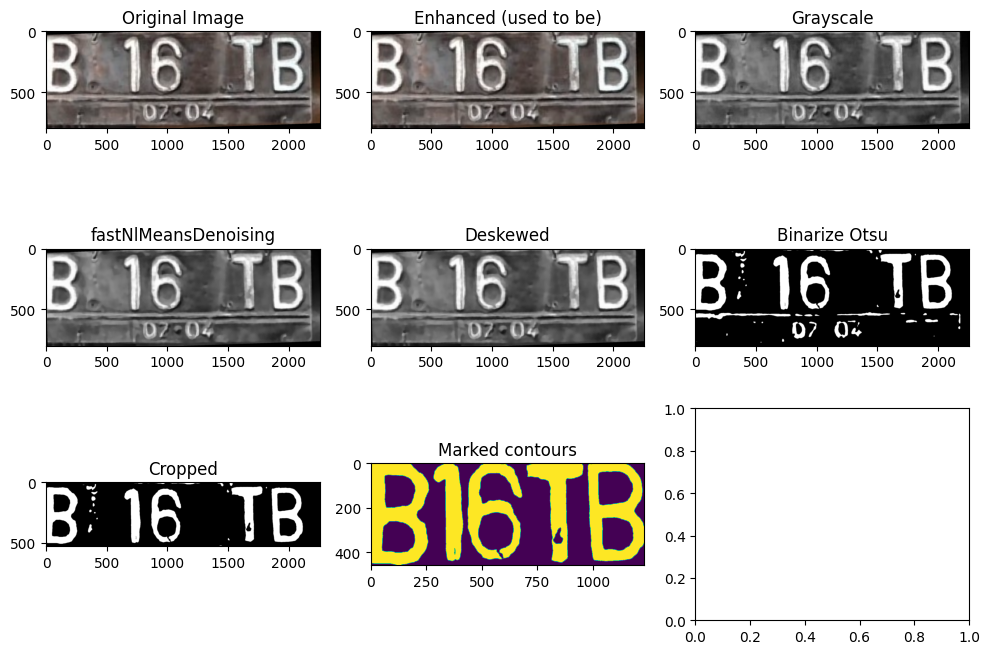

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(10,7))

image = readImage(imgPath)

ax[0,0].imshow(image)
ax[0,0].set_title('Original Image')
print(1)

enhanced = image
ax[0,1].imshow(enhanced)
ax[0,1].set_title('Enhanced (used to be)')
print(2)

gray = grayscale(enhanced)
ax[0,2].imshow(gray, cmap='gray')
ax[0,2].set_title('Grayscale')
print(3)

denoised = denoise(gray)
ax[1,0].imshow(denoised, cmap='gray')
ax[1,0].set_title('fastNlMeansDenoising')
print(4)

deskewed = denoised #rotateManual(denoised)
ax[1,1].imshow(deskewed, cmap='gray')
ax[1,1].set_title('Deskewed')
print(5)

image_otsu = otsuThres(deskewed)
ax[1,2].imshow(image_otsu, cmap = 'gray')
ax[1,2].set_title('Binarize Otsu')
print(6)

cropped = cropImage(image_otsu)
ax[2,0].imshow(cropped, cmap='gray')
ax[2,0].set_title('Cropped')
print(7)

marked = markContour2(cropped)
ax[2,1].imshow(marked)
ax[2,1].set_title('Marked contours')
print(8)

print(image.shape)

fig.tight_layout()
plt.show()


In [13]:
def has_alnum(text):
    """Check if a text has at least one letter and one number."""
    return re.search('[a-zA-Z]', text) is not None and re.search('[0-9]', text) is not None

def bestResult(image):
    # Get the results from both functions
    easy_result = easyRead(image)
    tess_result = tessRead(image)
    
    # Check if the texts have at least one letter and one number
    easy_has_alnum = has_alnum(easy_result)
    tess_has_alnum = has_alnum(tess_result)
    
    # If only one result has both a letter and a number, return it
    if easy_has_alnum and not tess_has_alnum:
        return easy_result
    elif tess_has_alnum and not easy_has_alnum:
        return tess_result
    
    # If both results have a letter and a number, return the longest one
    if easy_has_alnum and tess_has_alnum:
        if len(easy_result) >= len(tess_result):
            return easy_result
        else:
            return tess_result
    
    # If neither result has a letter and a number, return the longest one
    if len(easy_result) >= len(tess_result):
        return easy_result
    else:
        return tess_result




In [14]:
print('\nBest Result:', bestResult(marked))

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



Best Result: B16VB
